# Working with Raster - Mosaicing
<div style='background:#B1F9E3; color:#000000' class= 'alert alert-box'>
Raster mosaic can be done easily with the merge() function in Rasterio. Here, we will show you how to mosaic four DEM raster and create a seamless raster.
    </div>
    

In [1]:
import rasterio as rio
import os
from glob import glob

In [2]:
print(rio.__version__)

1.3.6


In [3]:
# List all dem files with glob() function
dirpath= "SRTM_SKA/"
out_fp = "SRTM_SKA/DEM_Mosaic.tif"

# Make a search criteria to select the DEM files
filter_file = "*.tif"
q = os.path.join(dirpath, filter_file)
print(q)

SRTM_SKA/*.tif


We will use glob() fuction to create list all rastetr in /SRTM_SK folder.

In [4]:
allfiles = glob(q)
allfiles

['SRTM_SKA\\n11_e076_1arc_v3.tif',
 'SRTM_SKA\\n11_e077_1arc_v3.tif',
 'SRTM_SKA\\n12_e076_1arc_v3.tif',
 'SRTM_SKA\\n12_e077_1arc_v3.tif']

In [5]:
srtmDEM=rio.open(allfiles[0])

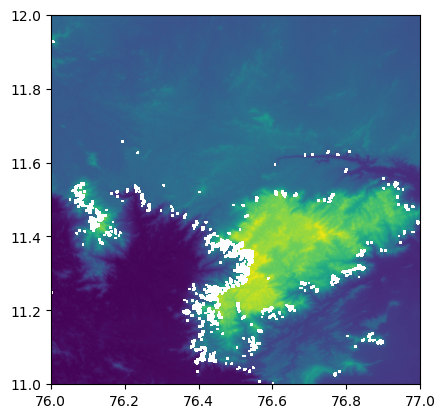

<Axes: >

In [6]:
from rasterio.plot import show
channel = 1
show(srtmDEM, channel)

In [7]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in allfiles:
    src = rio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic

[<open DatasetReader name='SRTM_SKA\n11_e076_1arc_v3.tif' mode='r'>,
 <open DatasetReader name='SRTM_SKA\n11_e077_1arc_v3.tif' mode='r'>,
 <open DatasetReader name='SRTM_SKA\n12_e076_1arc_v3.tif' mode='r'>,
 <open DatasetReader name='SRTM_SKA\n12_e077_1arc_v3.tif' mode='r'>]

<Axes: >

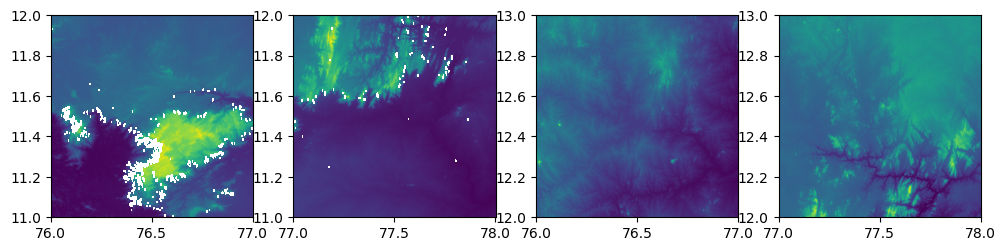

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
show(src_files_to_mosaic[0], ax=ax1)
show(src_files_to_mosaic[1], ax=ax2)
show(src_files_to_mosaic[2], ax=ax3)
show(src_files_to_mosaic[3], ax=ax4)

In [9]:
from rasterio.merge import merge
mosaic, out_trans = merge(src_files_to_mosaic)

In [10]:
# Copy the metadata
out_meta = src.meta.copy()

new_crs={'init': 'epsg:4326'} 

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": new_crs
                 }
                )

In [11]:
with rio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

In [12]:
MOSAIC_DEM=rio.open(out_fp)

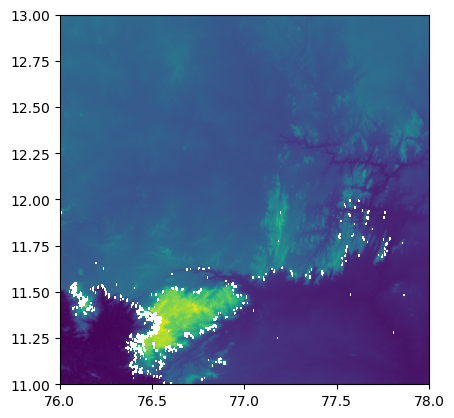

<Axes: >

In [13]:
show(MOSAIC_DEM, channel)

In [14]:
# Reproject after Mosaicking

In [15]:
import rasterio as rio
from rasterio.warp import reproject, Resampling, calculate_default_transform

#projection Parameters
dst_crs = "EPSG:32643"  # UTM Zone 43 N
inputRaster = "SRTM_SKA/DEM_Mosaic.tif"
outputRaster = "SRTM_SKA/DEM_Mosaic_prj.tif"

#opening raster Data

with rio.open(inputRaster) as src:
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

    # set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": 0,  # replace 0 with np.nan
        }
    )

    with rio.open(outputRaster, "w", **dst_kwargs) as dst:
        # iterate through bands
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

In [16]:
demprj = rio.open("SRTM_SKA/DEM_Mosaic_prj.tif")

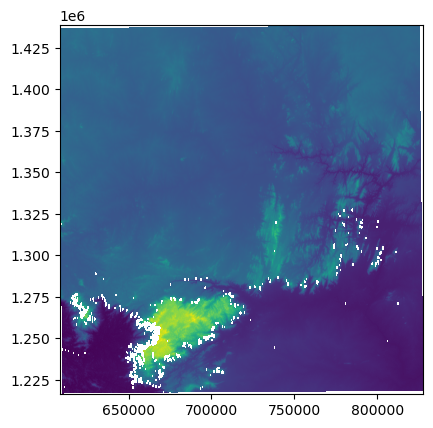

<Axes: >

In [17]:
show(demprj)